<center> <h1>TUPRAS METUSTATSCLUB DATATHON</h1> </center>

Petroleum refineries use a variety of physical and chemical processes to transform crude oil into products including gasoline, jet fuel, LPG kerosene and diesel.

The refinery uses process and laboratory metrics to control unit operations. Critical metrics that determine refinery profitability are estimated using process and laboratory variables from production. Due to operating limitations in the Plant-X unit of our ABC Refinery, D measurement (Conversion Rate) may only be measured once a day. As a result of this circumstance, operational interventions to improve product efficiency are not being carried out successfully in the units that have a direct impact on profitability.

To put everything in a nutshell,  o predict D conversion rate we will follow steps that are given below.
1. First Look to Data
2. Data Visualization & Preprocessing
3. Feature Engineering
4. Train & Evaluation

**Note:** This project based on real life data and because of privacy policy data is not published with notebook. In addition, notebook is updated to improve succes rate and visualization of the project.


## 1. First Look to Data

The data set is encoded to preserve privacy policy. Brief information of features:

1. **Y1** 1st Zone Temperature Process Difference Value
2. **Y2** 2nd Zone Temperature Process Difference Value
3. **E1** Element_1 Laboratory Measurement
4. **E2** Element_2 Laboratory Measurement
5. **A1** A Chemical Flow Rate
6. **Y3** 3rd Zone Temperature Process Difference Value
7. **Y4** 4th Zone Temperature Process Difference Value
8. **Y5** 5th Zone Temperature Process Difference Value
9. **Y6** 6th Zone Temperature Process Difference Value
10. **U1** Product Density
11. **U2** Product Flow Rate
12. **O1** Chemical Flow Rate
13. **O2** Chemical Flow Rate
14. **D** Conversion Ratio (Target)

In [1]:
import pandas as pd
import missingno as msno

import seaborn as sns
sns.set_style("darkgrid")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from mlxtend.evaluate import bias_variance_decomp
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import max_error, mean_absolute_error
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, optimizers

import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBRegressor

In [2]:
# Load data
df_train = pd.read_excel("Datathon_Plant_X.xlsx")
df_test = pd.read_excel("predict.xlsx")

# Combine train & prediction
df = pd.concat([df_train, df_test], axis=0)

# Unnamed: 0 represents date data of the data set so it's renamed.
df.rename(columns = {'Unnamed: 0':'date'}, inplace = True)

# Because of combining 2 data sets indexes of data set repeats itself.
# So data set is reindexed.
df.reset_index(inplace=True, drop=True)

# Spare raw data
df_copy = df.copy()
df.head()

,date,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,U1,U2,O1,O2,D
0,2014-05-15 00:00,3.200980,9.658993,NaN,NaN,4448.771308,33.471559,14.767730,19.796307,15.725165,752.452933,6587.005853,2.6433,10768.178760,NaN
1,2014-05-15 01:00,3.615716,9.302299,NaN,NaN,4442.398566,33.421821,14.845213,19.950811,16.305541,752.461803,6588.156991,2.6433,9895.346884,NaN
2,2014-05-15 02:00,3.748671,9.526543,NaN,NaN,4447.961145,33.784009,15.387849,20.214004,17.253103,752.328113,6586.293877,0.8811,9039.178904,NaN
3,2014-05-15 03:00,3.828601,9.540441,NaN,NaN,4446.466744,31.479599,14.830375,20.323768,17.994465,751.932141,6585.942271,0.8811,11391.700931,NaN
4,2014-05-15 04:00,3.880042,9.704919,NaN,NaN,4454.121402,34.578727,16.221921,20.945486,18.570945,751.422418,6586.498556,1.7622,10656.509979,NaN


In [3]:
# Only date is object column which will be float after split
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11834 entries, 0 to 11833
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    11834 non-null  object 
 1   Y1      11832 non-null  float64
 2   Y2      11832 non-null  float64
 3   E1      68 non-null     float64
 4   E2      71 non-null     float64
 5   A1      11832 non-null  float64
 6   Y3      11832 non-null  float64
 7   Y4      11832 non-null  float64
 8   Y5      11832 non-null  float64
 9   Y6      11832 non-null  float64
 10  U1      11832 non-null  float64
 11  U2      11832 non-null  float64
 12  O1      11834 non-null  float64
 13  O2      11834 non-null  float64
 14  D       438 non-null    float64
dtypes: float64(14), object(1)
memory usage: 1.4+ MB


Because the D value can be measured once a day and our dataset is hour based, there are a lot of NaN values on D feature. However, another noticable thing is that E1 and E2 values have even more NaN values. We will figure out this in following sections.

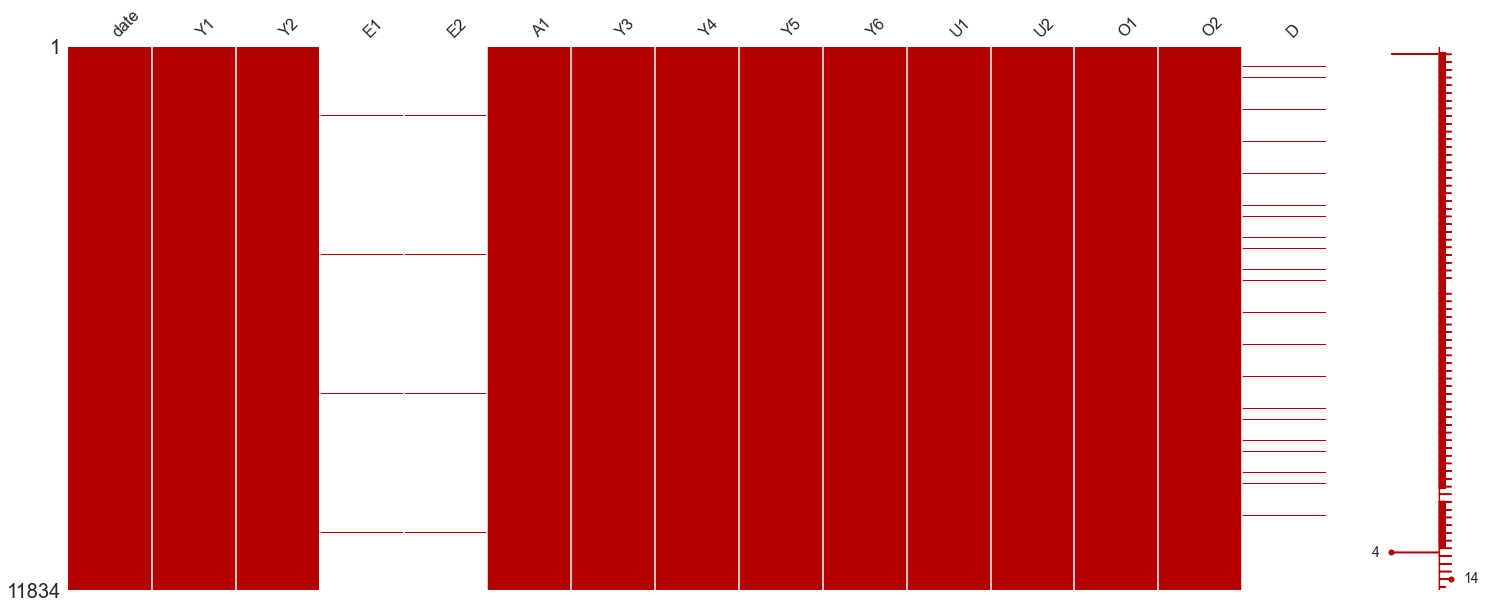

In [4]:
msno.matrix(df, color=(180/255, 0/255, 0/255));

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Y1,11832.0,4.379341,1.479318,-3.956198,3.546813,4.306175,5.075496,12.904879
Y2,11832.0,9.834977,2.726721,-4.703843,8.030767,9.651960,11.841275,29.630608
E1,68.0,2.772088,3.743223,0.000000,0.979000,1.424000,2.581000,24.920000
E2,71.0,3.502714,8.417556,0.097900,0.965650,1.424000,2.727850,68.823702
A1,11832.0,2877.215908,358.680042,29.941672,2672.413358,2845.590356,2951.728280,4462.595284
Y3,11832.0,36.068783,3.118233,-3.325959,34.218195,35.965092,37.730922,50.416129
Y4,11832.0,14.791475,3.806884,-3.290484,12.095603,15.157878,17.138070,25.921590
Y5,11832.0,21.021300,3.046256,-2.737114,19.037717,21.220180,23.257523,27.392031
Y6,11832.0,14.390324,4.998085,-4.338448,10.473832,14.197972,17.963303,28.558419
U1,11832.0,747.257865,2.342209,662.832645,746.239405,747.681732,748.807021,763.568158


## 2. Data Preprocessing & Visualization

The hour based data set is encoded wrongly which includes 29 February at 2015. Yet, February 2015 has 28 days not 29. That is why the data set must be shifted 1 day further. Main reason of it is may be the sensor that measures the D conversion rate. Because of date column type is not datetime, it can not be shifted with pandas attributes. Therefore, it will be reindexed from beginning to the end. 

In addition, another error that caused by sensor is wrong time encoded data's. Both in train and test data includes one distinctively encoded data and they will be removed. These are:

In [6]:
df[(df.index==154) | (df.index == 11009)]

,date,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,U1,U2,O1,O2,D
154,2014-05-21 09:55,NaN,NaN,NaN,0.9345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8811,11110.260928,NaN
11009,2015-08-15 15:48,NaN,NaN,NaN,2.7857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,11620.898409,NaN


You may ask how we found these indexes. The answer is actually simple, at first 29 Feburary is dropped from the data set. Then, data is converted datetime and if minute is not equal to 0 it is obtained. Short code of it is given below as commented. To prevent any failure in case you want to try the code raw data is assigned to processed data at last.

In [7]:
day_start_idx = df[df.date == "2015-02-29 00:00"].index[0]
df.drop(df.index[day_start_idx:day_start_idx+24], axis=0, inplace=True)

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M")
df["minute"] = df.date.dt.minute
print("Distinct minute datas are:", df[df.minute != 0])
df = df_copy.copy()


Distinct minute datas are:                      date  Y1  Y2  E1      E2  A1  Y3  Y4  Y5  Y6  U1  U2  \
154   2014-05-21 09:55:00 NaN NaN NaN  0.9345 NaN NaN NaN NaN NaN NaN NaN   
11009 2015-08-15 15:48:00 NaN NaN NaN  2.7857 NaN NaN NaN NaN NaN NaN NaN   

           O1            O2   D  minute  
154    0.8811  11110.260928 NaN      55  
11009  0.0000  11620.898409 NaN      48  


In [8]:
# Drop distinct data
df.drop([154,11009], axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
# Reindex datetime to shift data properly
df["date"] = pd.date_range('2014-05-15 00:00', end = '2015-09-19 23:00', freq= 'H')

# Observe each feature from datetime data
df["year"] = df.date.dt.year
df["month"] = df.date.dt.month
df["dayofmonth"] = df.date.dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['dayofyear'] = df['date'].dt.dayofyear
df["hour"] = df.date.dt.hour

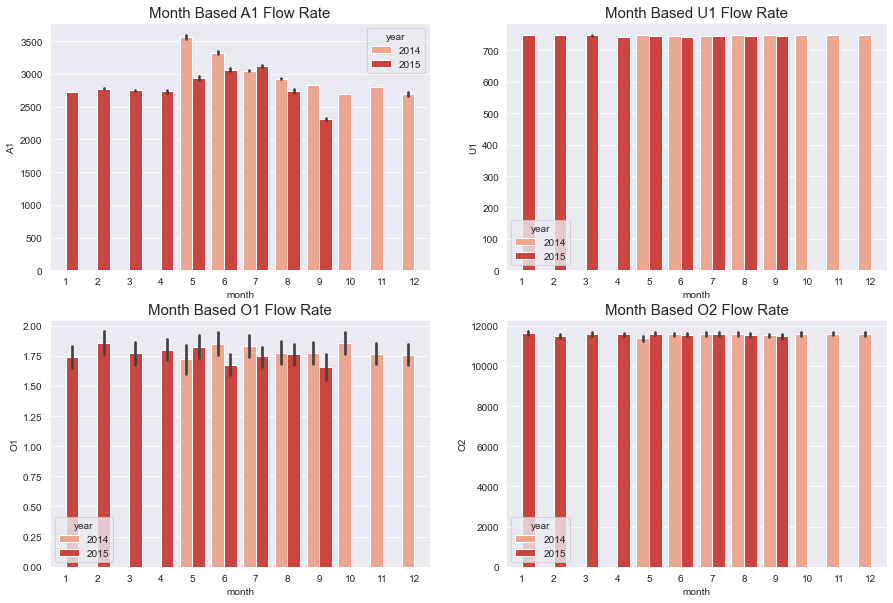

In [9]:
font = {"fontsize":10, "fontweight":"bold"}

sns.set_palette("RdGy")

fig, axes = plt.subplots(2,2, figsize=(15, 10))

sns.barplot(x="month", y="A1", data=df, ax=axes[0, 0],hue="year",
           palette="Reds")
axes[0, 0].set_title("Month Based A1 Flow Rate",
                    fontsize=15)

sns.barplot(x="month", y="U1", data=df, ax=axes[0, 1],hue="year",
           palette="Reds")
axes[0, 1].set_title("Month Based U1 Flow Rate",
                    fontsize=15)

sns.barplot(x="month", y="O1", data=df,ax=axes[1, 0],hue="year",
           palette="Reds")

axes[1, 0].set_title("Month Based O1 Flow Rate",
                    fontsize=15);

sns.barplot(x="month", y="O2", data=df,ax=axes[1, 1],hue="year",
           palette="Reds")

axes[1, 1].set_title("Month Based O2 Flow Rate",
                    fontsize=15);

When we check the graph noticable dates are around December 2014 and days around September 2014. Also flow rate of U2 significantly and continuously drops from March 2015 to May 2015. Instead of an measurement error there may be specific condition happened at those months.

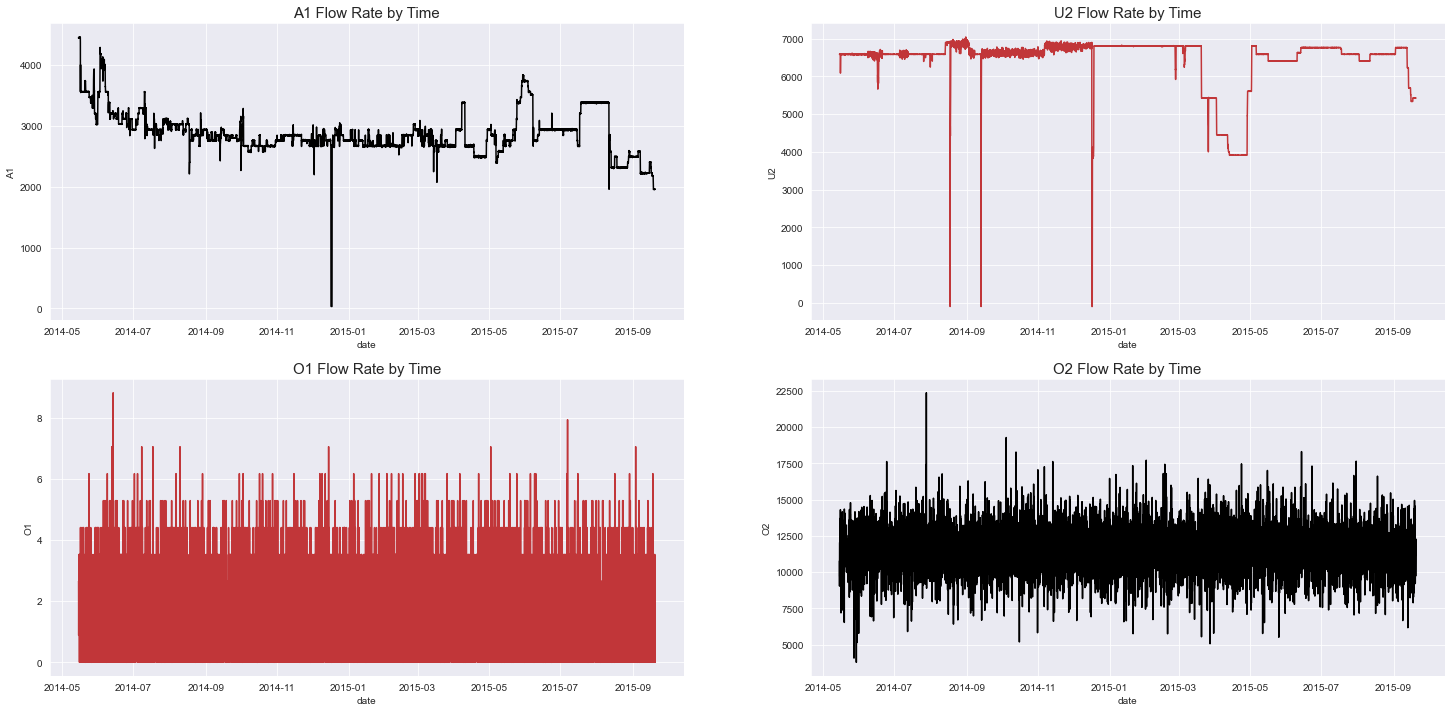

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(25, 12))


sns.lineplot(x="date", y="A1",
             data=df, color="black", ax=axes[0, 0])
axes[0, 0].set_title("A1 Flow Rate by Time",
                    fontsize=15)

sns.lineplot(x="date", y="U2",
             data=df,  ax=axes[0, 1])
axes[0, 1].set_title("U2 Flow Rate by Time",
        fontsize=15)

sns.lineplot(x="date", y="O1",
             data=df, ax=axes[1, 0])
axes[1, 0].set_title("O1 Flow Rate by Time",
                    fontsize=15)

sns.lineplot(x="date", y="O2",
             data=df, color="black", ax=axes[1, 1]);
axes[1, 1].set_title("O2 Flow Rate by Time",
                    fontsize=15);


Because of O1 was a bit complex to understand from date graph, at first density is shown. Then, hour, month and quarter based values regarding to each year is also shown. Seems like this feature does not vary a lot and it has some specific values. Instead of continuous being discrete makes us to wonder what is the reason behind it.

<AxesSubplot:xlabel='quarter', ylabel='O1'>

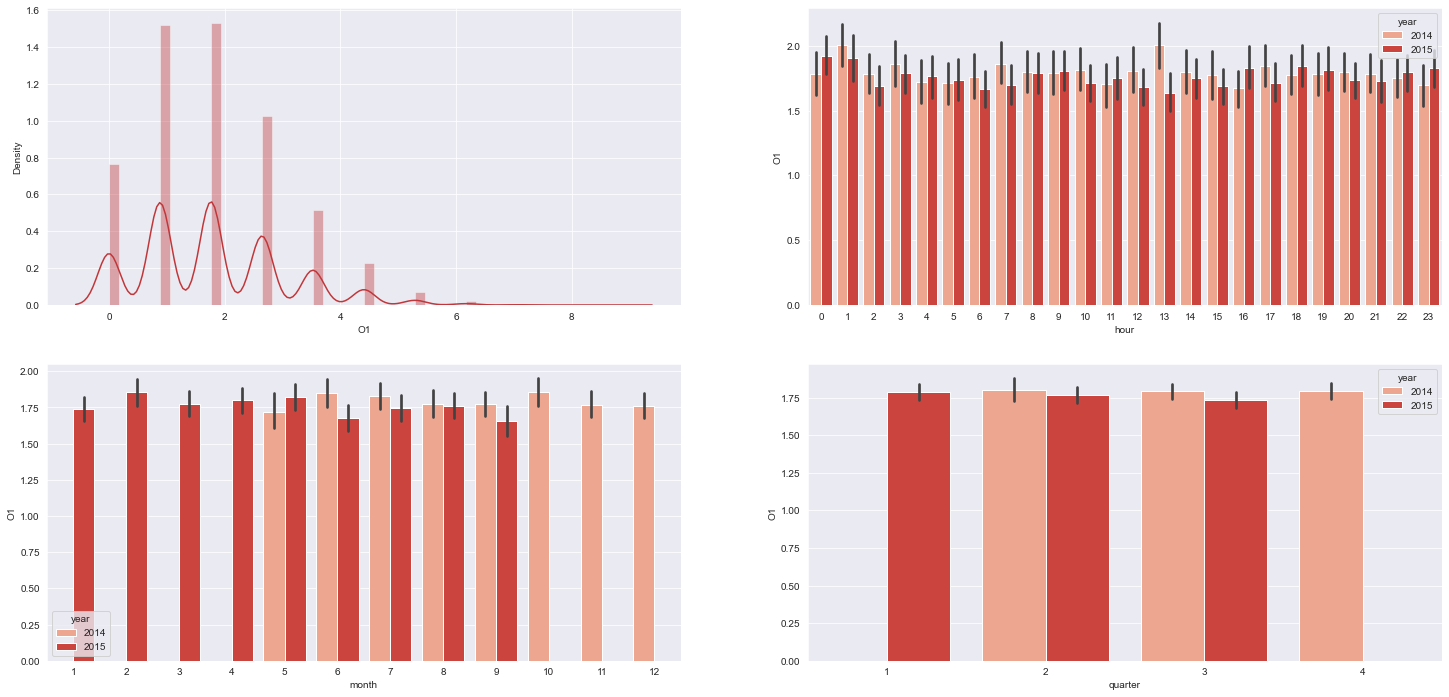

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(25, 12))

sns.set_palette("RdGy")

sns.distplot(df["O1"], ax=axes[0, 0])
sns.barplot(x="hour", y="O1", data=df, hue="year",
            palette="Reds", ax=axes[0, 1])
sns.barplot(x="month", y="O1", data=df, hue="year",
            palette="Reds", ax=axes[1, 0])
sns.barplot(x="quarter", y="O1", data=df, hue="year",
            palette="Reds", ax=axes[1, 1])


It can be seen from the graph D conversion ratio peaks suddenly at December 2014. Meanwhile, zone based temperature difference process values goes down. It seems something happened that day and it would be better to  remove that data point from the data set. Moreover, at January 2015 D value drops several times, but process values still continue as stabilized. This means, there are other factors that affects D value. 

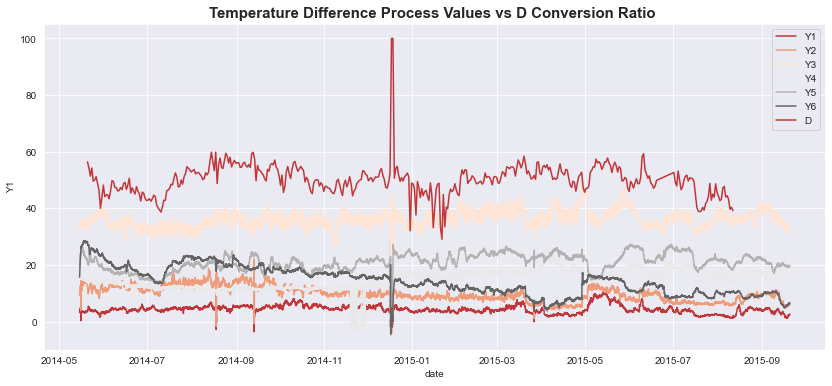

In [12]:
plt.figure(figsize=(14,6))

cols = ["Y1","Y2", "Y3", "Y4", "Y5", "Y6","D"]
sns.set_palette("RdGy")
for col in cols:
    sns.lineplot(x="date", y=col, data=df, label=col);
plt.title("Temperature Difference Process Values vs D Conversion Ratio ",
         fontdict={'fontsize':15, "fontweight":"bold"});

In order to check if data set has outlier for each column it is visualized with seperated boxplots. It seems there are lot of outliers on each feature, but because of we will use tree based algorithms data does not require normalization and outlier handling.

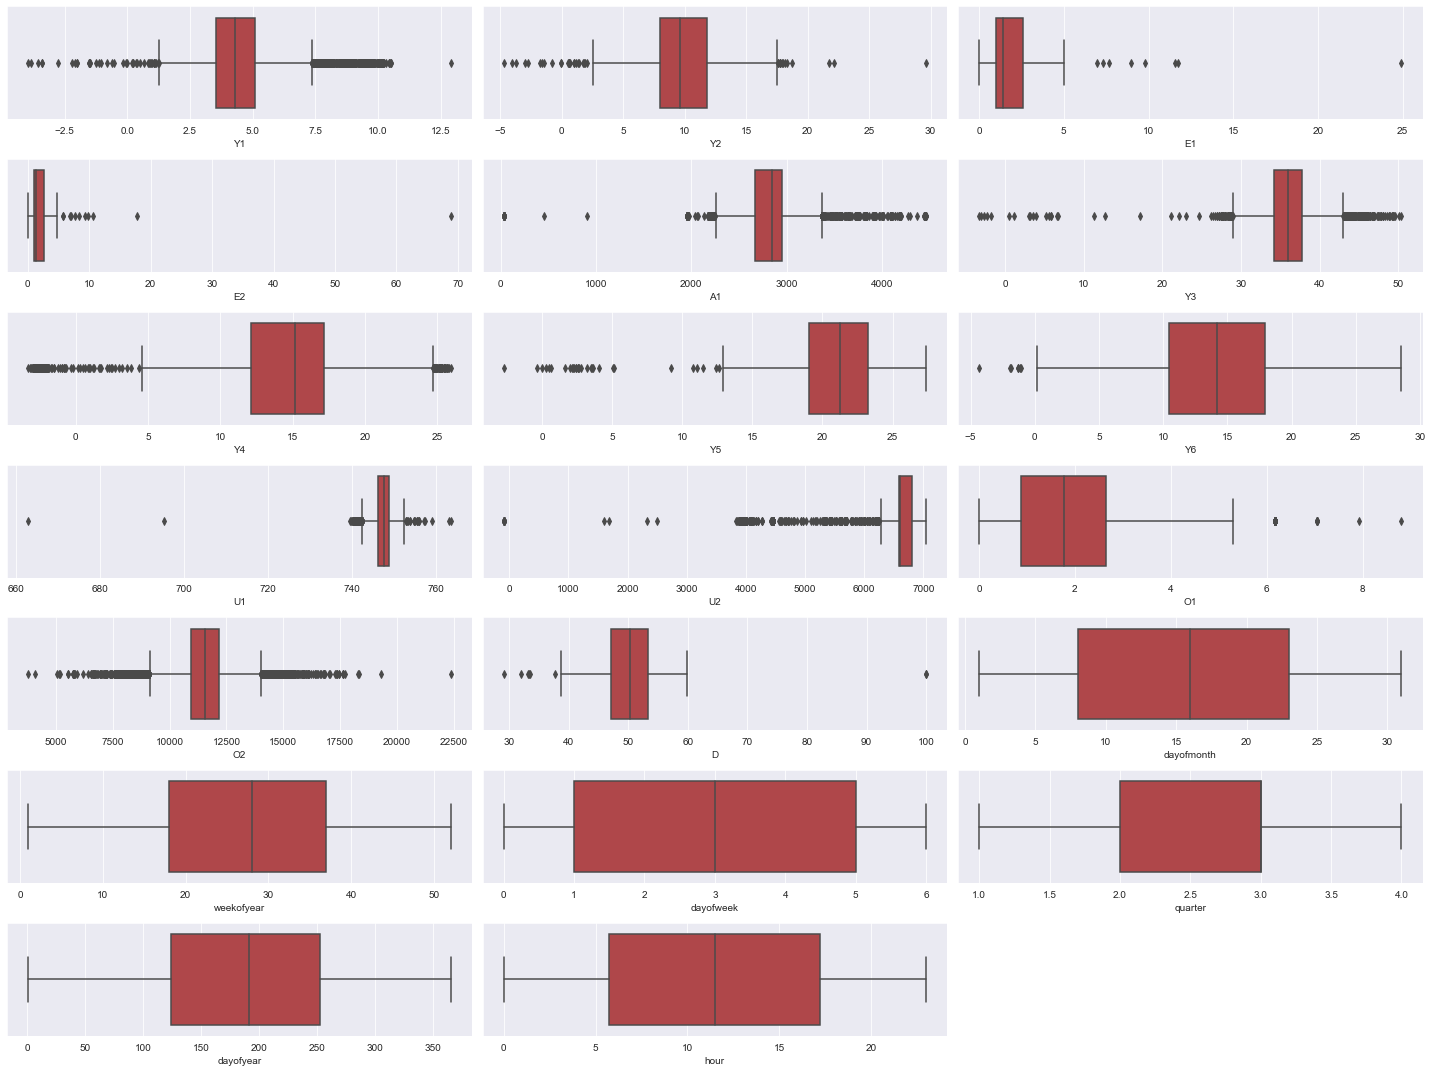

In [13]:
sns.set_palette("RdGy")
def outlier_box(col,row,fig,size,dataset,features):
    ft = list(features)                                  # Kullanıcının girdiği değişkenlerin listeye alınması
    sayac = 1                                           # Subplotta kullanılacak sıralama için 1'den başlayacak sayaç
    plt.figure(figsize = (fig,size))                     # Boyutları kullanıcının belirleyebilmesi için figsize parametre olarak alınıyor
    for ea_col in list(features):
        plt.subplot(col,row,sayac)                       # Alınan col ve row paramatreleriyle tablo matrisi oluşturuluyor
        sns.boxplot(dataset[ea_col])                      # Boxplot grafiği giren her değişken için uygulanıyor
        plt.tight_layout()                               # Tabloların sıkışık durmaması için tight_layout kullandık
        sayac += 1                                       # Tablo sıralamasını değiştirebilmek için sayacı artırdık

outlier_box(7,3,20,15,df.drop(["date","year","month"], axis=1),
            df.drop(["date","year","month"], axis=1).columns)
plt.savefig("densities.png")

We have said that D value measured once a day. To demonstrate it notnull D values are shown below. In order to increase our confidence on data set we will check if is there a duplication when we group not null D values by their years and dayofyears.


In [14]:
df[df.D.notnull()].head(5)

,date,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,...,O2,D,year,month,dayofmonth,weekofyear,dayofweek,quarter,dayofyear,hour
132,2014-05-20 12:00:00,3.609231,12.704128,NaN,NaN,3743.145561,34.400404,14.402499,21.257610,28.059274,...,12406.126474,56.434247,2014,5,20,21,1,2,140,12
156,2014-05-21 12:00:00,4.711384,11.534151,NaN,NaN,3562.017341,35.393247,14.051026,21.036052,26.234310,...,11399.559250,54.243913,2014,5,21,21,2,2,141,12
180,2014-05-22 12:00:00,3.960376,13.046616,NaN,NaN,3560.151596,37.873467,14.983565,24.364215,24.686947,...,11906.787334,51.388007,2014,5,22,21,3,2,142,12
204,2014-05-23 12:00:00,3.809510,10.660734,NaN,NaN,3558.111589,37.384745,14.589283,21.058634,25.782680,...,11789.684028,54.235757,2014,5,23,21,4,2,143,12
228,2014-05-24 12:00:00,3.600984,12.431635,NaN,NaN,3475.855494,37.540996,14.551313,21.679926,25.213176,...,10448.201865,49.597396,2014,5,24,21,5,2,144,12


In [15]:
max_D_count = max(df[df.D.notnull()].groupby(["year", "dayofyear"]).count()["D"])
if max_D_count > 1:
    print("D value measured more than once a day.")
else:
    print("D value only measured once a day.")

D value only measured once a day.


Likely D values, laboratory measurements are obtained once a week. To check it we will do same process as we did to D. Yet, while grouping data set to check if there are more than one measurement per a week, weekofyear is used instead of dayofyear. Also one distinct point is D value is measured at 12.00 and laboratory values are measured at 22.00.

In [16]:
df[(df.E1.notnull()) & (df.E2.notnull())].head(5)

,date,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,...,O2,D,year,month,dayofmonth,weekofyear,dayofweek,quarter,dayofyear,hour
166,2014-05-21 22:00:00,4.799225,12.036796,0.801,0.6408,3562.885472,36.732341,14.780650,24.143933,23.805997,...,10845.368386,NaN,2014,5,21,21,2,2,141,22
334,2014-05-28 22:00:00,1.978181,9.131056,0.712,0.9790,3203.554160,39.794533,13.362920,19.495241,23.310903,...,9296.320059,NaN,2014,5,28,22,2,2,148,22
502,2014-06-04 22:00:00,3.935466,13.141830,0.979,1.3884,3765.753129,34.918073,14.272290,18.379103,20.939415,...,12105.765998,NaN,2014,6,4,23,2,2,155,22
670,2014-06-11 22:00:00,4.596715,12.190475,0.890,0.5340,3201.531279,34.290871,13.235500,16.672650,18.766443,...,10195.336737,NaN,2014,6,11,24,2,2,162,22
838,2014-06-18 22:00:00,3.860187,11.651758,0.979,0.7120,3031.534709,35.058828,12.675854,16.278147,19.766771,...,11816.488752,NaN,2014,6,18,25,2,2,169,22


In [17]:
condition = (df.E1.notnull()) & (df.E2.notnull())
max_E1_count = max(df[condition].groupby(["year", "weekofyear"]).count()["E1"])
max_E2_count = max(df[condition].groupby(["year", "weekofyear"]).count()["E2"])
if max_E1_count > 1 or max_E2_count > 1:
    print("D value measured more than once a day.")
else:
    print("D value only measured once a week.")

D value only measured once a week.


At June 2015 looks like something significant at E2 laboratory measurement. Except that some peaks also happen time by time. Using tree based models prevent us to scale or normalize these outliers wrongly.

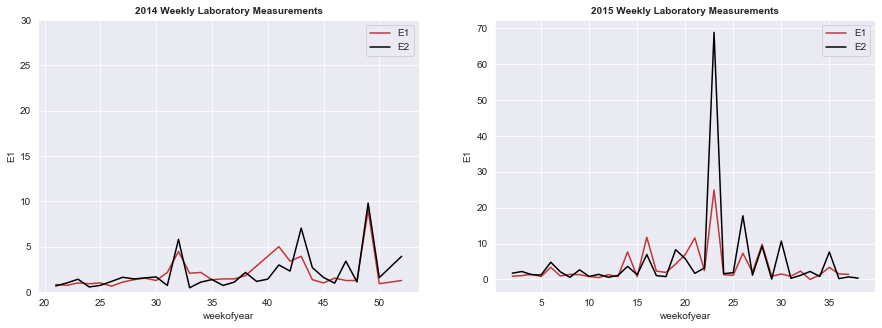

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_palette("RdGy")
df_viz = df[(df.weekofyear != 1) & (df.year==2014)]
sns.lineplot(x="weekofyear", y="E1", label="E1",
             data=df_viz, ax=axes[0])
sns.lineplot(x="weekofyear", y="E2", label="E2",color="black",
             data=df_viz, ax=axes[0]);
axes[0].set_ylim([0, 30])
axes[0].set_title("2014 Weekly Laboratory Measurements",
                 fontdict=font)


sns.lineplot(x="weekofyear", y="E1",label="E1",
             data=df[df.year==2015], ax=axes[1])

sns.lineplot(x="weekofyear", y="E2",label="E2",color="black", 
             data=df[df.year==2015], ax=axes[1]);

axes[1].set_title("2015 Weekly Laboratory Measurements",
                 fontdict=font);


Since laboratory values affects D conversion ratio until next week, it is filled by past values. Then for remaining NaN values it is filled by future values.

In [19]:
df.E1.fillna(method="ffill", inplace=True)
df.E2.fillna(method="ffill", inplace=True)

df.E1.fillna(method="bfill", inplace=True)
df.E2.fillna(method="bfill", inplace=True)

## 3. Feature Engineering

Because of data is encoded we are not able to obtain any information except their definitions. That is why, features are generated and tested if they are improving the success rate on test data or not. 

At first, season data is generated from months. It may affect data since different seasons have different average temperatures and weather conditions.

In [20]:
# Generation of season data by months

season = []
for i in range(len(df)):
    if df["month"][i] == 12 or df["month"][i] == 1 or df["month"][i] == 2:
        season.append(1)
    elif df["month"][i] == 3 or df["month"][i] == 4 or df["month"][i] == 5:
        season.append(2)
    elif df["month"][i] == 6 or df["month"][i] == 7 or df["month"][i] == 8:
        season.append(3)
    elif df["month"][i] == 9 or df["month"][i] == 10 or df["month"][i] == 11:
        season.append(4)

df["season"] = season

Y values were representing different temperature difference process values at same refinery. That is why all of their differences are summed to obtain total temperature difference process value per hour.

In [21]:
df["Y_total"] = df["Y1"] + df["Y2"] + df["Y3"] + df["Y5"] + df["Y6"]

Because of different chemicals thats flow may combined at one section or they may be flow from same pipes, their ratios with respect to each other are obtained.

In [22]:
df["density_based_u"] = df["U1"] * df["U2"] 
df["density_based_u"] = df["density_based_u"] / 1000

df["O2_A1_ratio"] = df["O2"] / df["A1"]

df["O2_O1_ratio"] = df["O2"] / df["O1"]
df["O2_O1_ratio"] = df["O2"] / 1000 

df["A1_O1_ratio"] = df["A1"] / df["O1"] 
df["A1_O1_ratio"] = df["A1"] / 1000

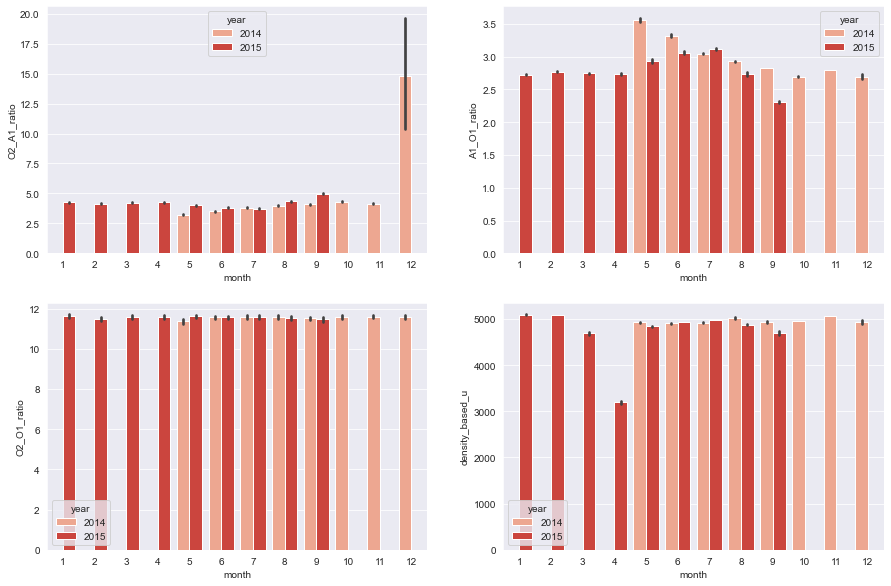

In [23]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

sns.barplot(x="month", y="O2_A1_ratio", hue="year",
            data=df,ax=axes[0, 0], palette="Reds")

sns.barplot(x="month", y="A1_O1_ratio", hue="year",
            data=df, ax=axes[0, 1], palette="Reds")

sns.barplot(x="month", y="O2_O1_ratio", hue="year",
            data=df, ax=axes[1, 0], palette="Reds")

sns.barplot(x="month", y="density_based_u", hue="year",
            data=df,ax=axes[1, 1], palette="Reds");


In order to represent a time series problem, and because of D data values measured once a day, past 24 values of D data are added to each measurement. Thus, we may extract a pattern if some specific hour based past values have more impact on measurement.

Because of D has only 438 not null values I decided to not use this technique, reason of it is it we got 11 features to use that technique and if we use it 24*11 + 13 = 277 features to predict D value with only 438 data points. That is why, we used mean of recent 24 hours of each day. 

In [24]:
cols = list(df.drop(["D", "date", "hour", "season", "quarter", "month",
        "dayofyear", "dayofweek", "dayofmonth", "weekofyear"], axis=1).columns)

df_progress = df[cols]

Because of D value is measured once a day, past 23 hours are thought to be affect it. That is why, every 23 hours before measuring D are averaged at measuring hour. 

In [25]:
# Generating shifted columns for each feature
for col in cols:
    for i in range(1,24):
        df_progress[col+str(i)] = df_progress[col].shift(i)

# Getting average for every feature
for col in cols:
    for i in range(1, 24):
        df_progress[col] += df_progress[col+str(i)]
    df[col] = df_progress[col] / 24

Train & split done to seperate input and output of data. Additionally, some feature are given below are dropped with backward elimination method to increase overall score.

In [26]:
df.reset_index(inplace=True, drop=True)


df_test = df.iloc[len(df_train):]
df_test = df_test[df_test.hour==12]
df_test.drop(["date","hour","dayofyear", "A1_O1_ratio","D",
              "O2_O1_ratio","E2", "Y2", "Y5", "Y6", "quarter"], axis=1, inplace=True)

df_train = df[df.D.notnull()]
df_train = df_train[~(df_train.D == 100)]
df_viz = df_train.copy()
df_viz.set_index("date", inplace=True)

df_train.drop(["date","hour","dayofyear", "A1_O1_ratio",
              "O2_O1_ratio","E2", "Y2", "Y5", "Y6", "quarter"], axis=1, inplace=True)

Here we decompose our signal below. By checcking our Trend data it seems our output does not increase or decrease steadily. Additionally, some gap occurs at July 2017. Residual values are distributed around 0 and looks like has no spectacular formation except around date Jan 2015.

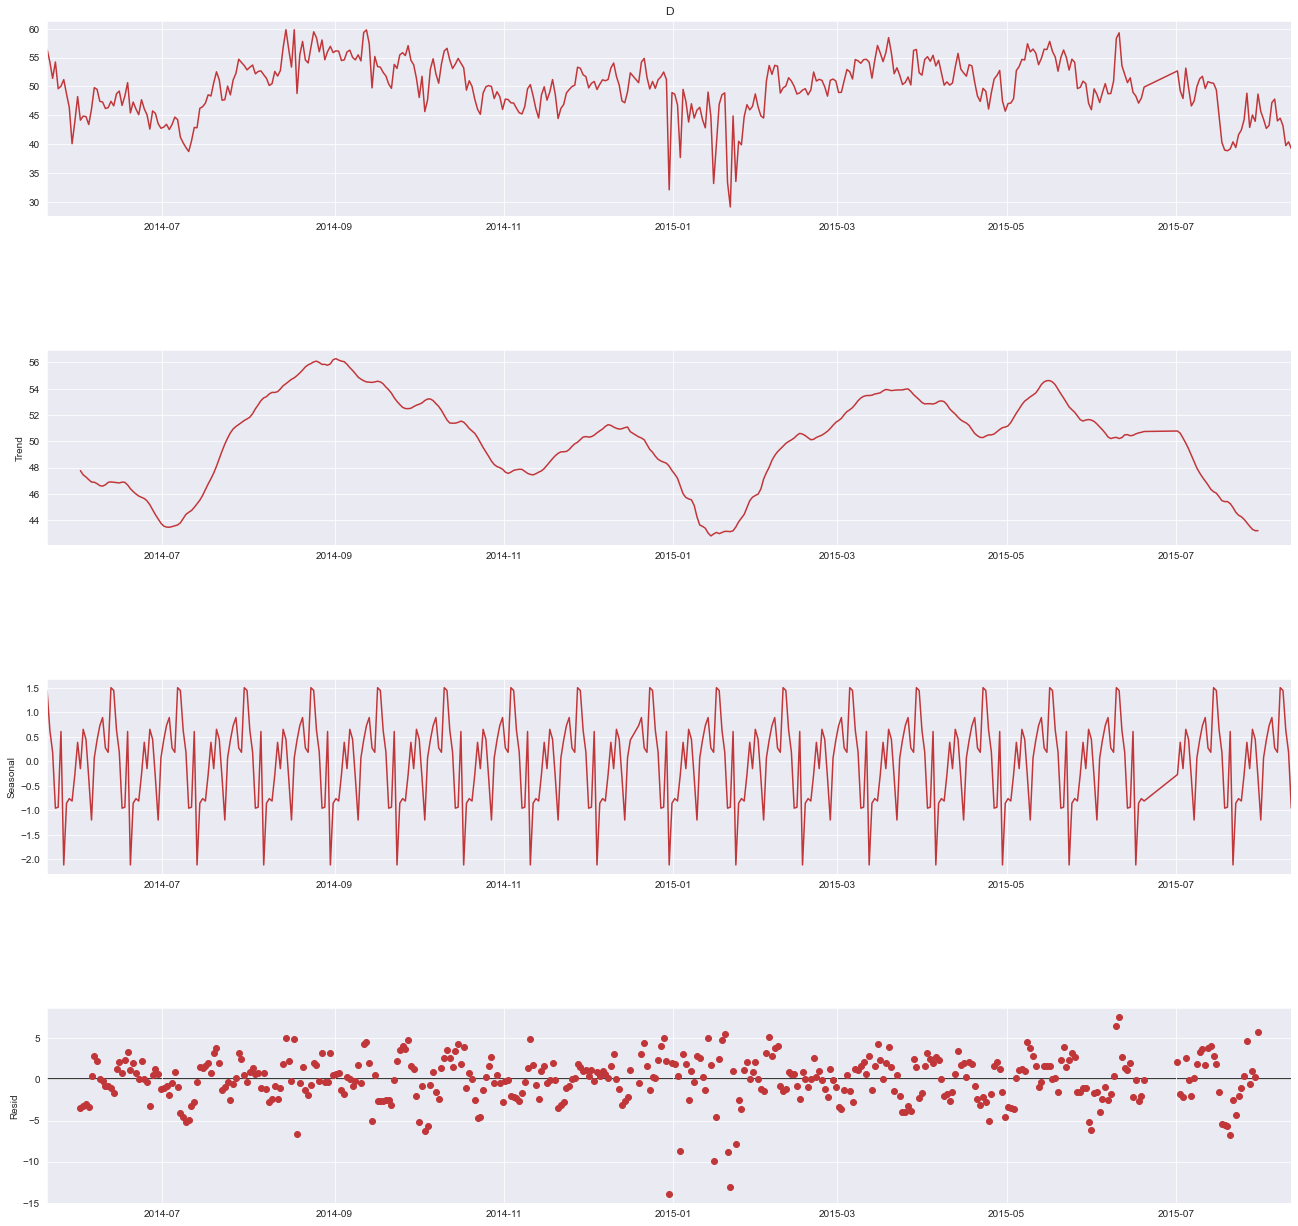

In [27]:
decomposition = seasonal_decompose(df_viz["D"], period=24)
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(20)

Autocorrelation measures relationship between current value and its past values. shows it's decrement as the lag increases by day. We can add until 5 shift to data set in order to increase our prediction. However, more important thing here is also the explainability. Therefore, shifted past days will not be added to data set. 

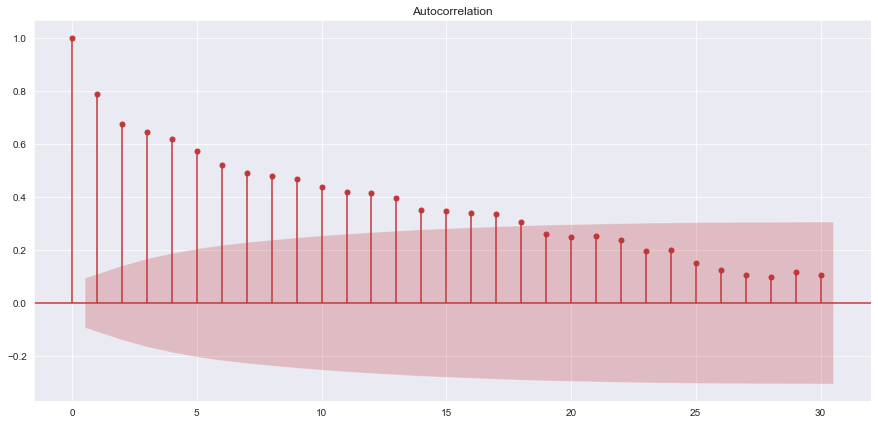

In [28]:
fig = plot_acf(df_viz["D"], lags=30);
fig.set_figwidth(15)
fig.set_figheight(7)

In [29]:
# Adding shifts to data set
"""
cols = ["dayofmonth", "month", "year", "weekofyear",
        "dayofweek", "season", "D"]
for col in df_train.drop(cols, axis=1):
    df_train[col+"_1"] = df_train[col].shift(1)
    df_test[col+"_1"] = df_test[col].shift(1)
    
""";

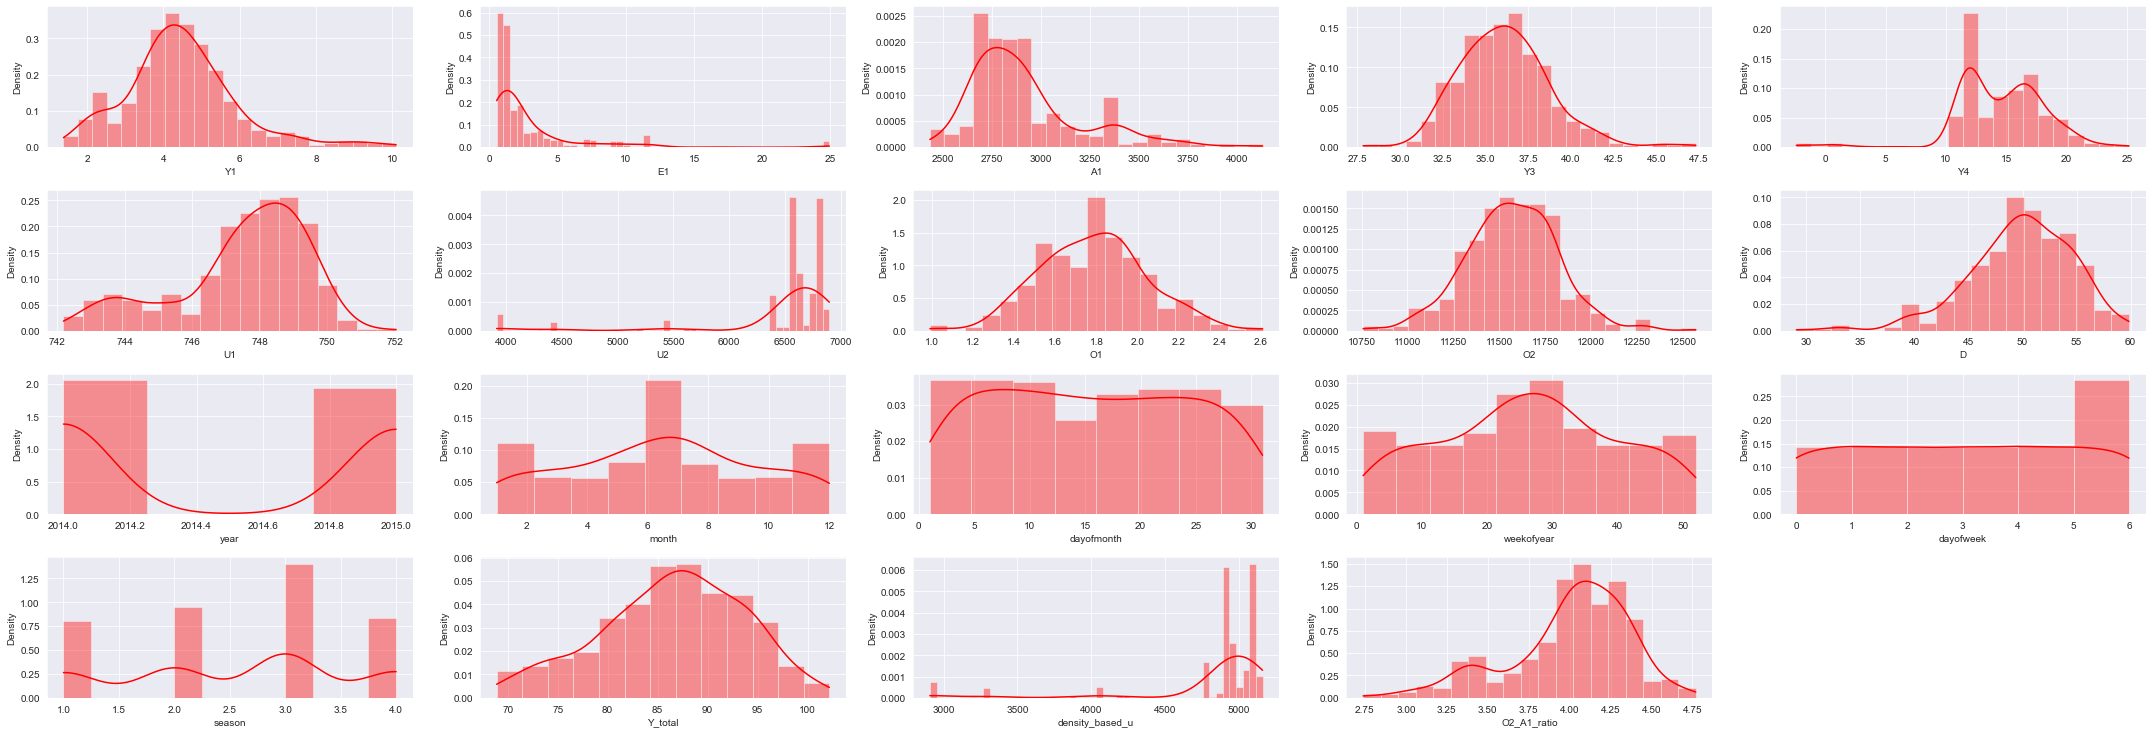

In [30]:
# Density plots of features
def outlier_box(col,row,fig,size,dataset,features):
    ft = list(features)                                  # Kullanıcının girdiği değişkenlerin listeye alınması
    sayac = 1                                           # Subplotta kullanılacak sıralama için 1'den başlayacak sayaç
    plt.figure(figsize = (fig,size))                     # Boyutları kullanıcının belirleyebilmesi için figsize parametre olarak alınıyor
    for i in range(len(ft)):
        plt.subplot(col,row,sayac)                       # Alınan col ve row paramatreleriyle tablo matrisi oluşturuluyor
        sns.distplot(dataset[ft[i]], color="red",
                    kde_kws={'clip': (dataset[ft[i]].min(),dataset[ft[i]].max())})                      # Boxplot grafiği giren her değişken için uygulanıyor
        plt.tight_layout()                               # Tabloların sıkışık durmaması için tight_layout kullandık
        sayac += 1                                       # Tablo sıralamasını değiştirebilmek için sayacı artırdık

outlier_box(6,5,30,15,df_train,df_train.columns)
plt.savefig("densities.png")

Correlation heatmap between input features are visualized to check if there is high correlation. As can be estimated, **density_based_u** has 100% correlation with **U2**.

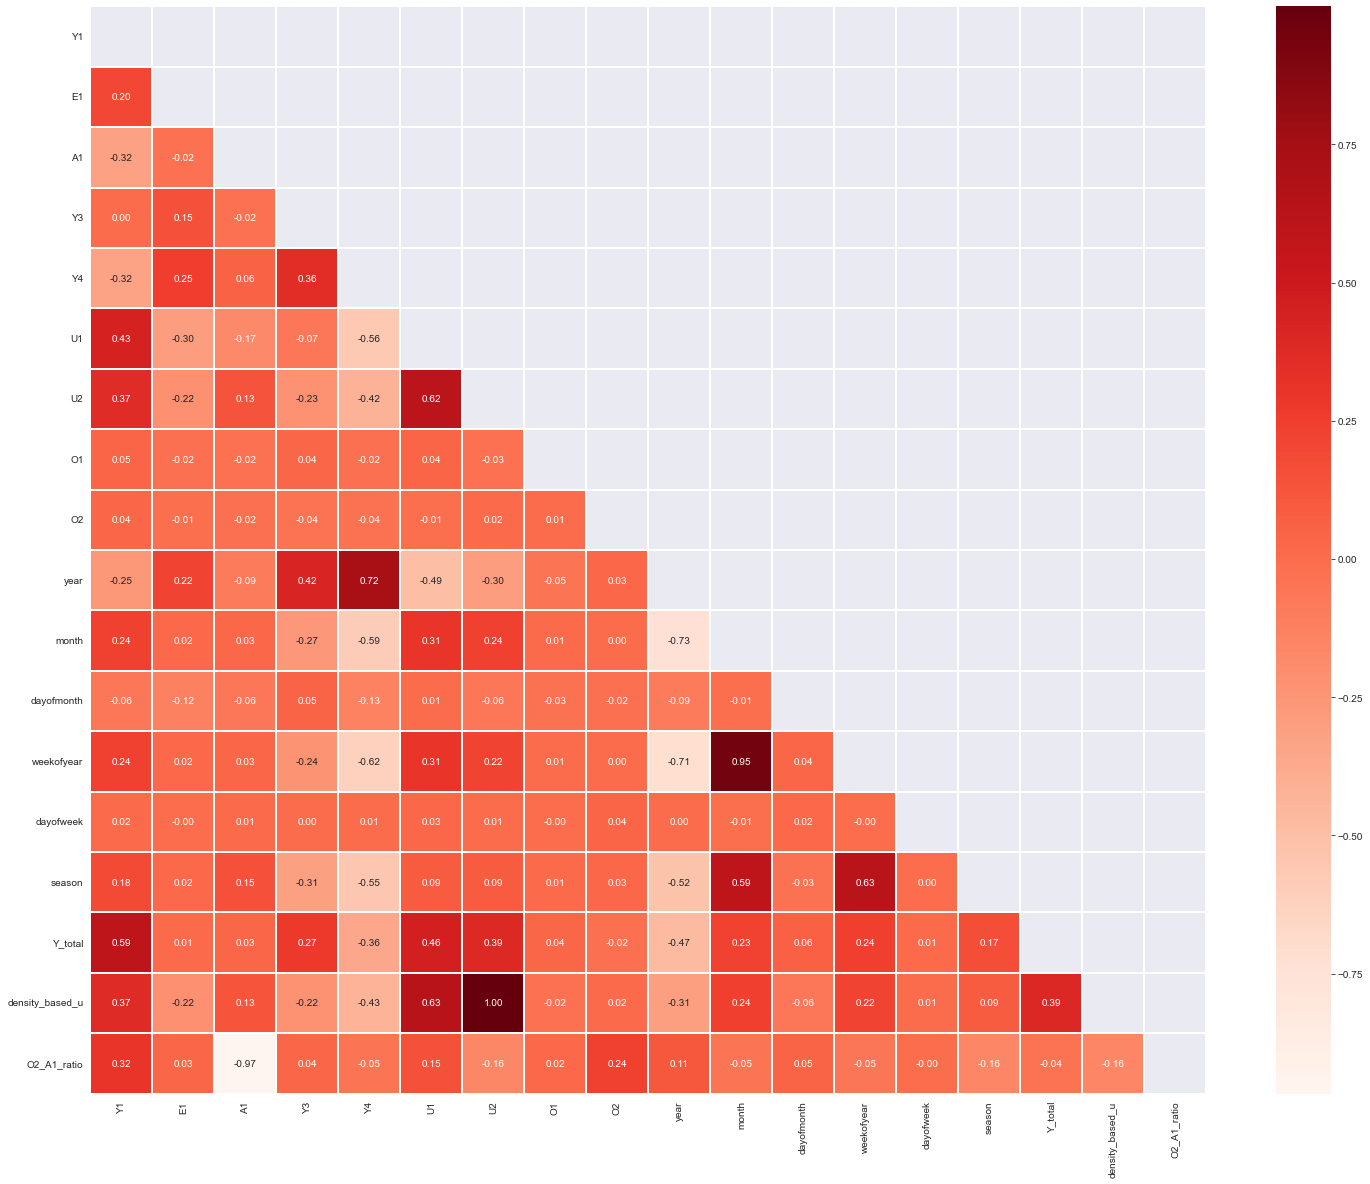

In [31]:
plt.figure(figsize=(25,20))
corr = df_train.drop(["D"], axis=1).corr()
matrix = np.triu(corr)
sns.heatmap(corr, linewidths=2, mask=matrix, cmap="Reds", annot=True, fmt=".2f")
plt.savefig("heatmap.png")

Text(0.5, 0, 'Correlations')

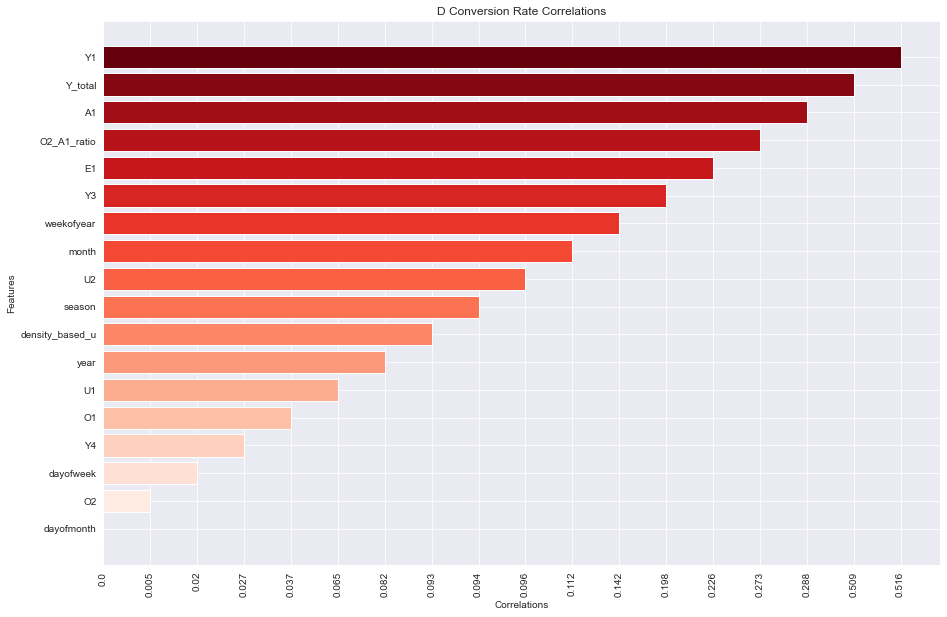

In [32]:
correlation_list = list()
for col in df_train.drop(["D"], axis=1).columns:
    correlation_list.append([col, abs(round(df_train['D'].corr(df_train[col]), 3))])

correlation_list = np.array(sorted(correlation_list, key=lambda x: x[1]))

color_map = cm.get_cmap('Reds', len(correlation_list))
color_list = [color_map(i) for i in range(len(correlation_list))]

plt.figure(figsize=(15, 10))
plt.barh(list(correlation_list[:, 0]), correlation_list[:, 1], color=color_list)
plt.xticks(rotation=90)
plt.title("D Conversion Rate Correlations")
plt.ylabel("Features")
plt.xlabel("Correlations")

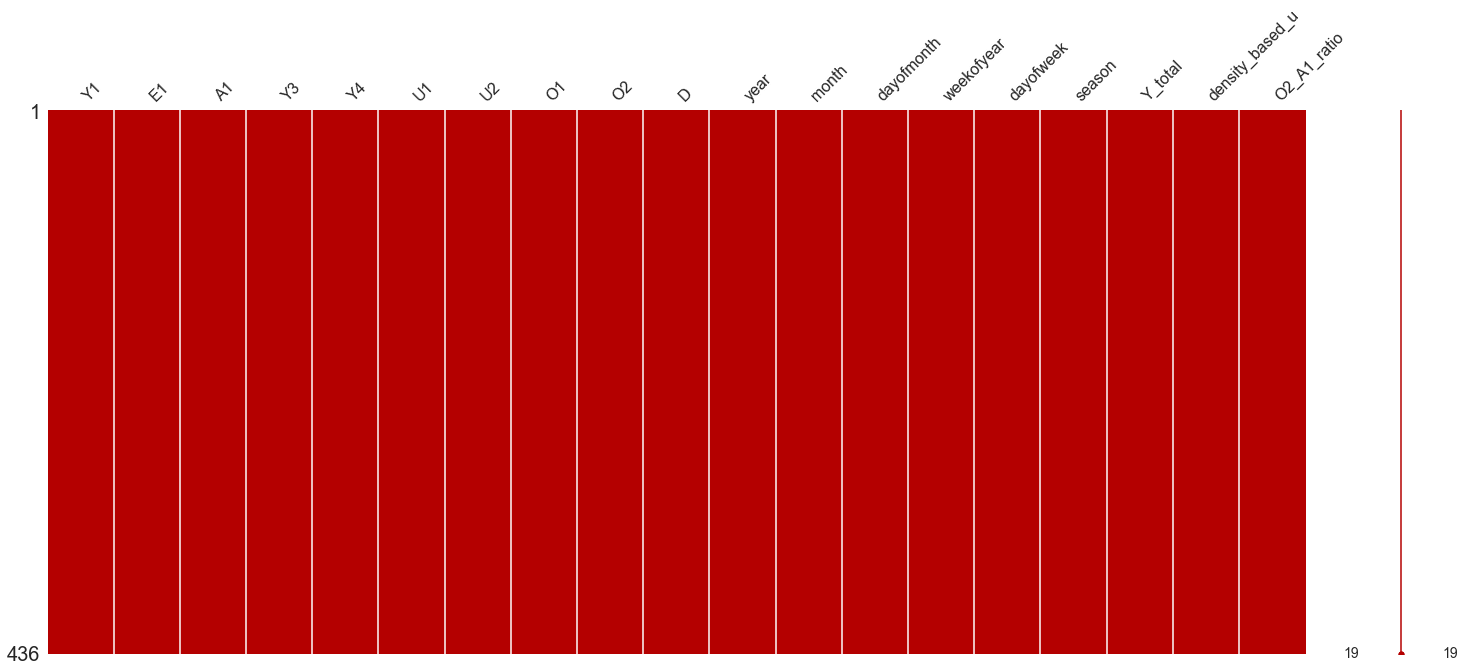

In [33]:
# Checking if there is still NaN values.
msno.matrix(df_train,  color=(180/255, 0/255, 0/255));

## 4. Train & Evaluation

In [34]:
# First split to input and output, then 80% as train and 20% as test data.
x, y = df_train.drop("D", axis=1), df_train["D"]
X_train, X_test = df_train.drop("D", axis=1)[:int(len(df_train)*0.8)], df_train.drop("D", axis=1)[int(len(df_train)*0.8):]
y_train, y_test = df_train["D"][:int(len(df_train)*0.8)], df_train["D"][int(len(df_train)*0.8):]

Different regression algorithms are tried to find the best solution for the problem. Their results will be compared with different metrics. These metrics are MAE, MSE, 

In [35]:
#XGBOOST fit
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = model_xgb.predict(X_test)

#Support vector regression
model_svr = SVR(C=0.8, epsilon=0.2, kernel='poly')
model_svr.fit(X_train, y_train)
svr_train_pred = model_svr.predict(X_train)
svr_pred = model_svr.predict(X_test)

#Decision tree regressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(X_train,y_train)
dtr_train_pred = model_dtr.predict(X_train)
dtr_pred = model_dtr.predict(X_test)

#Random forest regressor
model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
model_rfr.fit(X_train,y_train)
rfr_train_pred = model_rfr.predict(X_train)
rfr_pred = model_rfr.predict(X_test)

#Lasso regressor
model_lasso = Lasso(alpha=0.00001, normalize=True)
model_lasso.fit(X_train, y_train)
lasso_train_pred = model_lasso.predict(X_train)
lasso_pred = model_lasso.predict(X_test)

#Light gbm
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(X_train, y_train)
lgbm_train_pred = model_lgbm.predict(X_train)
lgbm_pred = model_lgbm.predict(X_test)

#Catboost
model_catboost = CatBoostRegressor(verbose=0)
model_catboost.fit(X_train, y_train)
catboost_train_pred = model_catboost.predict(X_train)
catboost_pred = model_catboost.predict(X_test)

#GBM
model_gbm = GradientBoostingRegressor()
model_gbm.fit(X_train, y_train)
gbm_train_pred = model_gbm.predict(X_train)
gbm_pred = model_gbm.predict(X_test)

In [36]:
# DataFrame to hold predictions and visualization
Model_Bag = pd.DataFrame({
     'XGB': model_xgb.predict(X_train),
     'SVR': model_svr.predict(X_train),
     'DTR': model_dtr.predict(X_train),
     'RFR': model_rfr.predict(X_train),
     'LASSO': model_lasso.predict(X_train),
     'LGBM' : model_lgbm.predict(X_train),
     'CatBoost': model_catboost.predict(X_train),
     'GBM' : model_gbm.predict(X_train),
    })

In [37]:
metric_df = pd.DataFrame()
for i in range(Model_Bag.shape[1]):
    eval_metrics = {}
    
    #for i = 0 we are evaluating the xgboost
    y_true = y_train
    y_pred = Model_Bag.iloc[:,i]
    
    eval_metrics['Explained Variance Score'] = explained_variance_score(y_true, y_pred)
    eval_metrics['Maximum Error'] = max_error(y_true, y_pred)
    eval_metrics['Mean Absolute Error'] = mean_absolute_error(y_true, y_pred)
    eval_metrics['Mean Squared Error'] = mean_squared_error(y_true, y_pred)
    eval_metrics['Median Absolute Error'] = median_absolute_error(y_true, y_pred)
    eval_metrics['R2 Score'] = r2_score(y_true, y_pred)
    
    metric_df = metric_df.append(eval_metrics, ignore_index=True)


In [38]:
metric_df = metric_df.transpose()
metric_df.rename(columns={0: "XG Boost", 
                          1:'Support Vector Regressor', 
                          2:'Decision Tree Regressor', 
                          3:'Random Forest Regressor',
                          4:'LASSO',
                          5:'LGBM',
                          6:'CatBoost',
                          7:'GBM'
                          }, inplace=True)

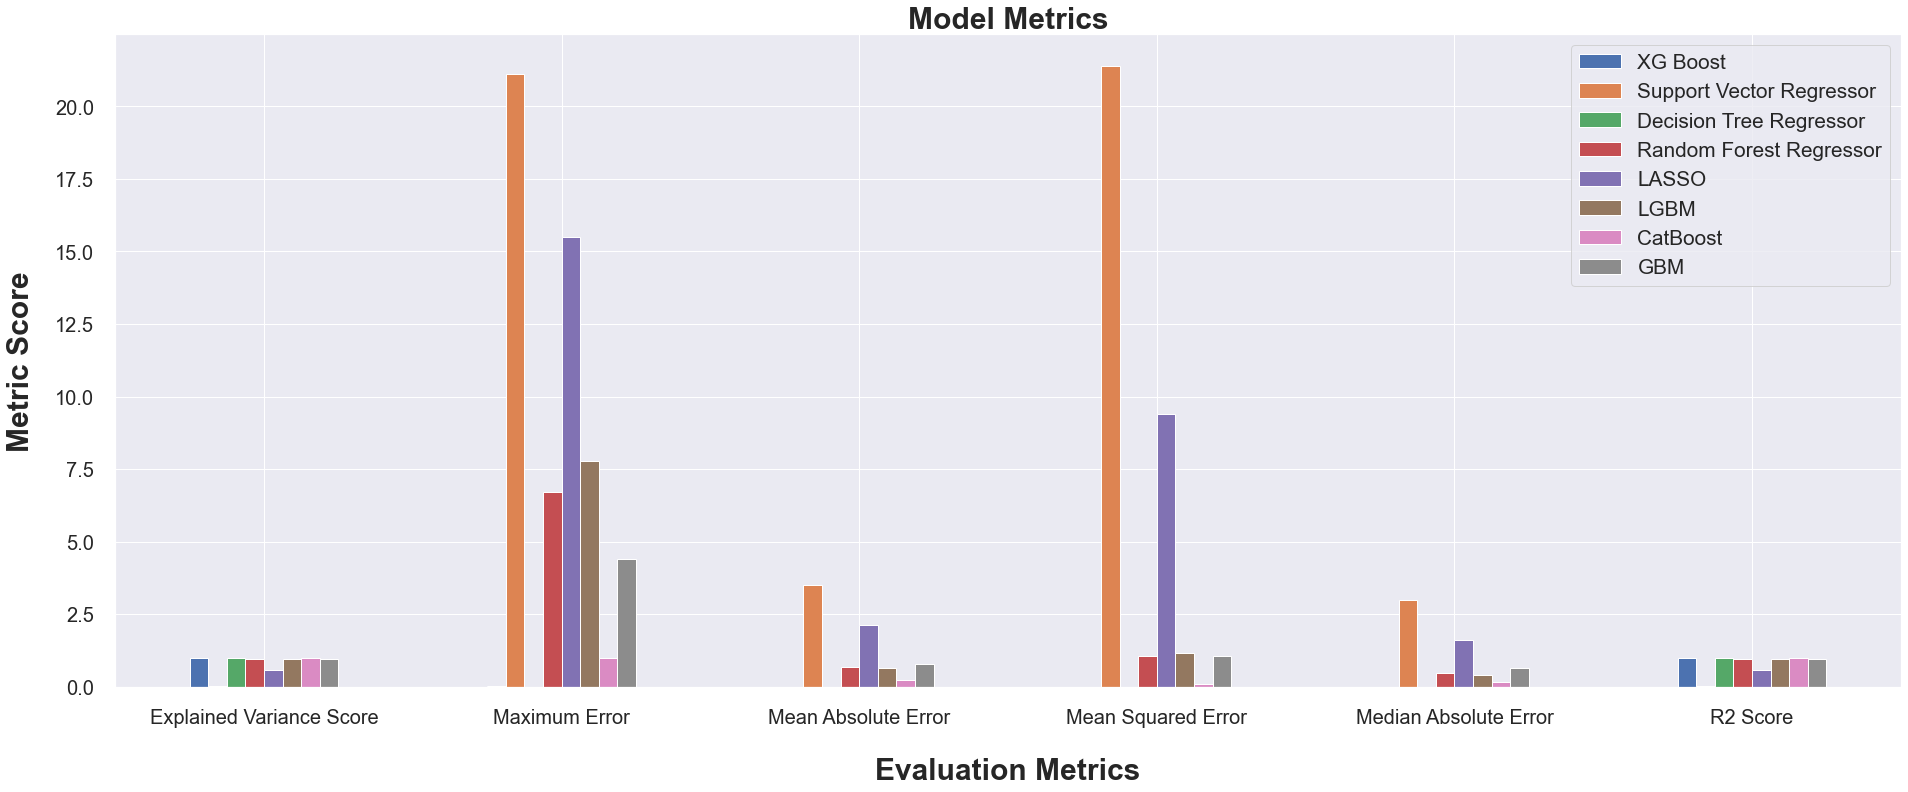

In [39]:
sns.set(rc = {'figure.figsize':(32,12)})
ax = metric_df.plot.bar(rot=0)
ax.legend(fontsize='xx-large')
ax.set_title('Model Metrics', fontsize = '30', fontdict=dict(weight='bold'))
ax.set_xlabel('Evaluation Metrics', fontsize = '30', fontdict=dict(weight='bold'))
ax.set_ylabel('Metric Score', fontsize = '30', fontdict=dict(weight='bold'))
ax.tick_params(axis='both', which='major', pad=15)
ax.yaxis.labelpad = 20
ax.xaxis.labelpad = 30
ax.title.labelpad = 40
plt.xticks(fontsize= '20') 
plt.yticks(fontsize= '20');

In [40]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_
# Hyperparameter tuning commented to prevent time waste
#hyperParameterTuning(X_train, y_train)

In [41]:
#Train to check output values
xgb_model_opt = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 3,
        min_child_weight = 5,
        n_estimators = 200,
        subsample = 0.5)

xgb_model_opt.fit(X_train, y_train)

catboost_regressor = CatBoostRegressor(depth=4, l2_leaf_reg=3,
                                       iterations=150,
                                       learning_rate=0.1,
                                       verbose=0)

catboost_regressor.fit(X_train, y_train)

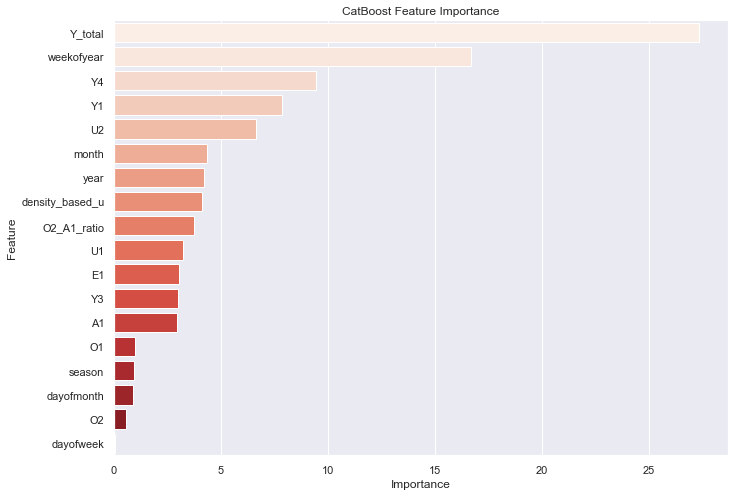

In [42]:
df_feature_importance = pd.DataFrame(catboost_regressor.get_feature_importance(prettified=True))
plt.figure(figsize=(11, 8))
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance, palette="Reds")
plt.title('CatBoost Feature Importance')
plt.xlabel("Importance")
plt.ylabel("Feature");

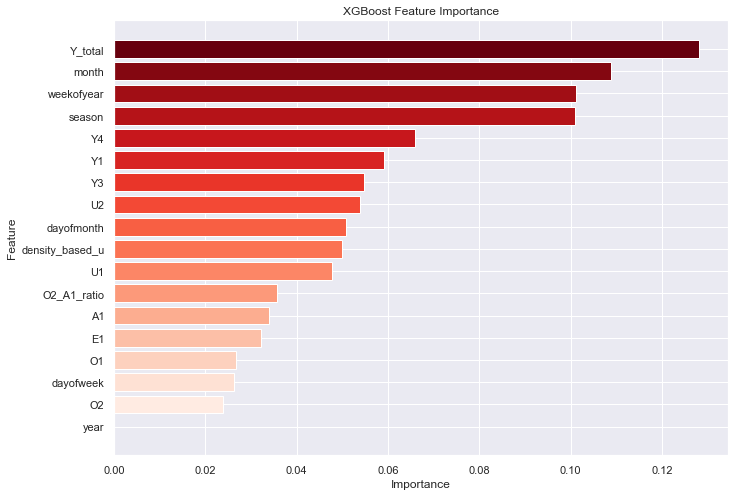

In [43]:
plt.figure(figsize=(11, 8))
color_list2 = [color_map(i) for i in range(len(df_train.drop("D", axis=1).columns))]
sorted_idx = xgb_model_opt.feature_importances_.argsort()
plt.barh(df_train.drop("D", axis=1).columns[sorted_idx],
         xgb_model_opt.feature_importances_[sorted_idx],
        color=color_list2)
plt.title('XGBoost Feature Importance')
plt.xlabel("Importance")
plt.ylabel("Feature");

In [44]:
cat_pred = catboost_regressor.predict(X_test)
xgb_pred = xgb_model_opt.predict(X_test)
ensemble_pred = (xgb_pred + cat_pred) / 2

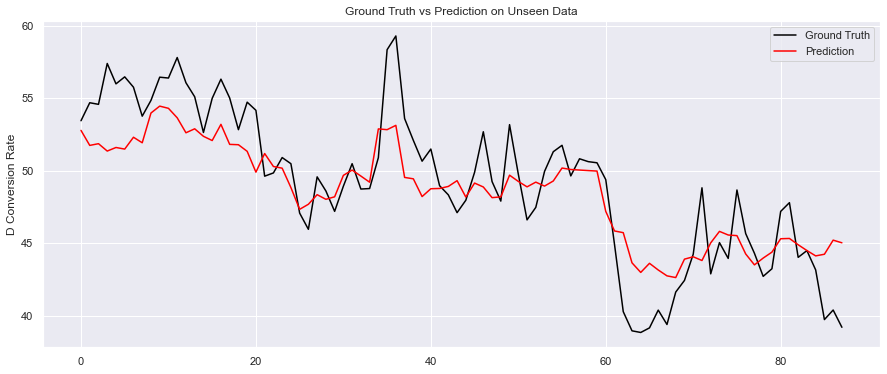

In [45]:
plt.figure(figsize=(15,6))
sns.lineplot(data=y_test.values, color="black", label="Ground Truth")
sns.lineplot(data=ensemble_pred, color="red", label="Prediction")
plt.title("Ground Truth vs Prediction on Unseen Data")
plt.ylabel("D Conversion Rate");

In [46]:
R2 = r2_score(y_test, ensemble_pred)
Adj_R2 = 1-(1-R2)*(len(X_test)-1)/(len(X_test)-len(df_train.columns)-1)
print("MSE:", mean_squared_error(y_test, ensemble_pred, squared=False),
      "\nMAE:", mean_absolute_error(y_test, ensemble_pred),
      "\nR2 Score:", R2,
      "\nAdjusted R2:", Adj_R2)

MSE: 2.704260551011397 
MAE: 2.1680862415607396 
R2 Score: 0.7304118106198312 
Adjusted R2: 0.6550856988812546


In [47]:
mse, bias, var = bias_variance_decomp(catboost_regressor,
                                    X_train.values, y_train.values,
                          X_test.values, y_test.values, loss="mse")

# Loss, Bias, Variance of Catboost model
print("MSE:", mse,
      "\nBias:", bias,
      "\nVariance:", var)

MSE: 9.777743867314717 
Bias: 8.836476151684177 
Variance: 0.9412677156305252


In [48]:
#Traing XGBoost and Catboost with all data
xgb_all = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 3,
        min_child_weight = 5,
        n_estimators = 200,
        subsample = 0.5)

xgb_all.fit(x.values, y)

catboost_all = CatBoostRegressor(depth=4, l2_leaf_reg=3,
                                       iterations=150,
                                       learning_rate=0.1,
                                       verbose=0)

catboost_all.fit(x, y)

In [49]:
cat_pred_test = catboost_all.predict(df_test.values)
xgb_pred_test = xgb_all.predict(df_test.values)

In [50]:
ensemble_pred_test = (cat_pred_test + xgb_pred_test) / 2

Since deep learning model require high data set, LSTM model is not used. Instead of it combination of Catboost and XGBoost is decided to be used.

In [51]:
"""
model = Sequential()

model.add(layers.LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x.shape[1], 1)))
model.add(layers.LSTM(units =64, activation='relu', return_sequences=True, input_shape = (x.shape[1], 1)))
model.add(layers.LSTM(units =32, activation='relu', return_sequences=False))

model.add(layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

x2 = x.to_numpy()
X = np.reshape(x2, (x2.shape[0], x2.shape[1], 1))
history = model.fit(X, y, epochs = 10, batch_size=2, validation_split=0.1)
""";

In [52]:
# Comnbining train and submission data to visualize
df_true = pd.concat([df_train, df_test], axis=0)
df_true.reset_index(drop=True, inplace=True)

In [53]:
# Collecting both train and submission outputs
cat_pred_train = catboost_all.predict(x.to_numpy())
xgb_pred_train = xgb_all.predict(x.values)

pred_train = (cat_pred_train + xgb_pred_train) / 2

cat_pred_test = catboost_all.predict(df_test.to_numpy())
xgb_pred_test = xgb_all.predict(df_test.values)

pred_test = (cat_pred_test + xgb_pred_test) / 2

total_pred = np.concatenate((pred_train, pred_test), axis=0)
df_pred = pd.DataFrame(total_pred, columns=["Prediction"])

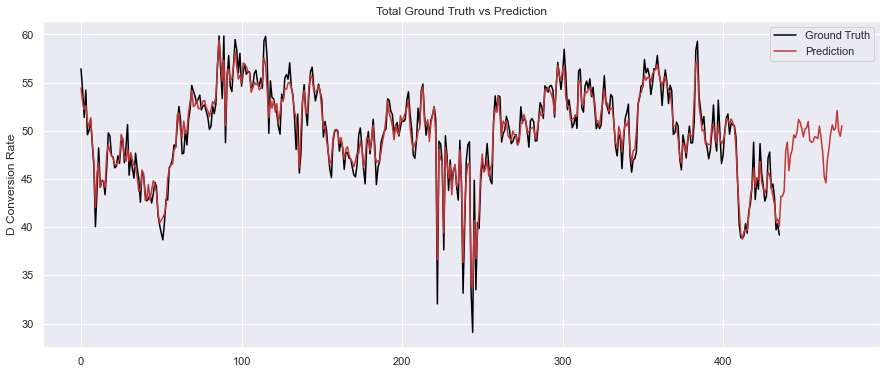

In [54]:
sns.set_palette("RdGy")
plt.figure(figsize=(15,6))
sns.lineplot(data=df_true["D"], color="black", label="Ground Truth")
sns.lineplot(data=df_pred, color="red")
plt.title("Total Ground Truth vs Prediction")
plt.ylabel("D Conversion Rate");